# Implementing a Multi-armed Bandit
We'll use classical Reinforcement Learning (Q-Learning) to solve a multi-armed bandit problem. Our agent has to balance between exploration and exploitation to maximize reward as fast as possible.

To estimate the reward for each arm, we use reward-average sampling together with epsilon-greedy exploration strategy.

In [1]:
%matplotlib inline

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class Bandit:
    def __init__(self, p_arms):
        assert all(0 <= p <= 1 for p in p_arms)
        self.p_arms = p_arms
    
    @property
    def n_arms(self):
        return len(self.p_arms)
    
    def pull_arm(self, arm):
        assert arm < len(self.p_arms)
        got_reward = random.random() < self.p_arms[arm]
        return 1 if got_reward else 0
    
class QTable:
    def __init__(self, actions):
        self.memory = {action: (0, 0) for action in actions}
        
    def update(self, action, reward):
        assert action < len(self.memory)
        k, q = self.memory[action]
        self.memory[action] = (k + 1, q + 1/(k + 1) * (reward - q))
        
    def get_q(self, action):
        assert action < len(self.memory)
        k, q = self.memory[action]
        return q
    
    def argmax(self):
        best_action = -1
        best_q = float('-inf')
        scrambled = list(self.memory.items())
        random.shuffle(scrambled)
        for action, (k, q) in scrambled:
            if q > best_q:
                best_q = q
                best_action = action
        
        return best_action
    
def should_explore(episode, epsilon, decay=10):
    return random.random() < (epsilon / (1 + episode/decay))

def split_cumsum(history):
    history = pd.Series(history)
    actions = sorted(history.unique())
    table = {action: (history == action).cumsum() for action in actions}
    return pd.DataFrame(table)

## Setting up the Environment
We create a bandit with 10 possible actions and fixed probability of reward for each of the 10 arms. The goal of the agent is to find the arm that maximizes reward. On our example, the best arm is the 4th one, with $P(reward) = 0.8$.

In [2]:
bandit = Bandit([0.1, 0.5, 0.6, 0.8, 0.1, 0.25, 0.6, 0.45, 0.75, 0.65]) # Probabiliy of reward
q_table = QTable(range(bandit.n_arms))
epsilon = 0.9 # Probability of exploring
history = []

for episode in range(10000):
    if should_explore(episode, epsilon):
        chosen_arm = random.randint(0, bandit.n_arms - 1)
    else:
        chosen_arm = q_table.argmax()
    
    history.append(chosen_arm)
    reward = bandit.pull_arm(chosen_arm)
    q_table.update(chosen_arm, reward)

We can inspect the Q-Function table to see what are the expected reward for each arm. Because our reward is either 0 or 1, the expected reward equates to the probability of getting a reward by pulling that arm.

In [3]:
q_table.memory

{0: (8, 0.12500000000000003),
 1: (8, 0.625),
 2: (9, 0.6666666666666666),
 3: (9757, 0.7897919442451586),
 4: (4, 0.25),
 5: (8, 0.375),
 6: (12, 0.5833333333333334),
 7: (9, 0.5555555555555556),
 8: (178, 0.7528089887640451),
 9: (7, 0.2857142857142857)}

Not too shabby, eh? Now, let's look how the proportion of arms pulled changes through time.

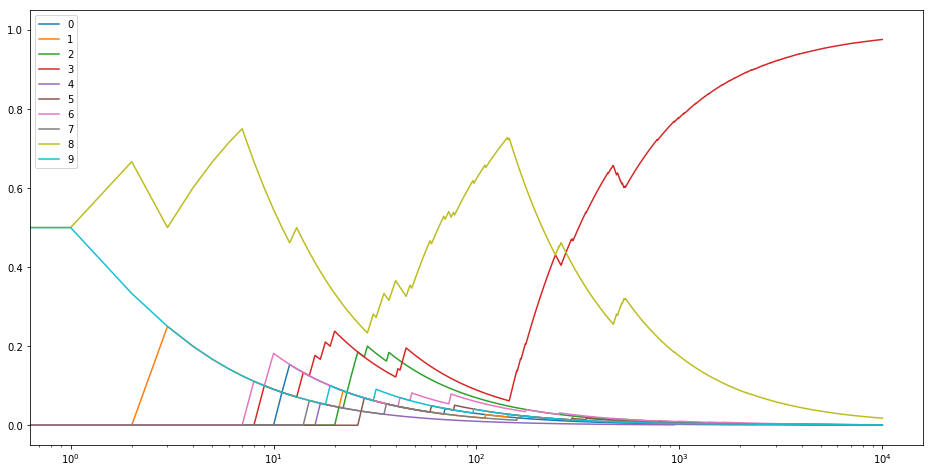

In [4]:
fig, ax = plt.subplots(figsize=(16, 8))
cumsum = split_cumsum(history)
cum_p = cumsum.div(cumsum.sum(axis=1), axis=0)
cum_p.plot(logx=True, ax=ax)

We can see that around the 100th episode, the agent starts choosing the 4th arm (number 3 in the chart) more and more. Hooray!

## Bonus: Vowpal Wabbit example
Haven't heard of Vowpal Wabbit? You can find more about this amazing tool [here](https://github.com/JohnLangford/vowpal_wabbit).

In [5]:
def dataset_from_bandit(bandit, rows):
    p_uniform = 1/bandit.n_arms
    for _ in range(rows):
        chosen_arm = random.randint(0, bandit.n_arms - 1)
        cost = 1 - bandit.pull_arm(chosen_arm)
        yield "{}:{}:{} |".format(chosen_arm + 1, cost, p_uniform)

In [6]:
with open('cb.txt', 'w') as fd:
    lines = '\n'.join(dataset_from_bandit(bandit, 50000))
    fd.write(lines)

In [7]:
# --cb_explore <number of actions>
!vw -d cb.txt --cb_explore 10 --epsilon 0.1 -f model.vw

final_regressor = model.vw
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = cb.txt
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.000000 0.000000            1            1.0        4 1:0.910000        1
0.050000 0.100000            2            2.0        3 1:0.910000        1
0.050000 0.050000            4            4.0        2 1:0.910000        1
0.050000 0.050000            8            8.0       10 1:0.910000        1
0.043750 0.037500           16           16.0        2 4:0.910000        1
0.034375 0.025000           32           32.0       10 4:0.910000        1
0.323437 0.612500           64           64.0        5 4:0.910000        1
0.539062 0.754687          128          128.0        3 4:0.910000        1
0.470312 0.401562          256          256.0       10 9:0.910000        1
0.413477 0.356641         

In [8]:
!echo "|" | vw -t -i model.vw

only testing
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = 
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
    n.a.     n.a.            1            1.0  unknown 4:0.910000        1

finished run
number of examples per pass = 1
passes used = 1
weighted example sum = 1.000000
weighted label sum = 0.000000
average loss = n.a.
total feature number = 1


### Making sense of VW output
The prediction from Vowpal Wabbit translates to the action that should be taken, `4` in our case, followed by the probability `0.91`.
`4` is indeed the best action, with the highest probability of reward (or lowest probability of penalty), so the model was able to figure it out. The `0.91` comes from the exploration strategy, `epsilon-greedy`, which will explore 10% of the time, thanks to the parameter given in training, and will exploit the best action on the remaining 90%.
So, the probability of action `4` being chosen is
$$P(4) = P(4,exploit) + P(4,explore) = P(4 \mid exploit) P(exploit) + P(4 \mid explore) P(explore) = 1 * 0.9 + 0.1 * 0.1 = 0.91$$